In [23]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import seaborn as sns
import glob
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from scipy.stats import multivariate_normal
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans
import warnings
import json
import networkx as nx
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from scipy.linalg import sqrtm
from scipy.optimize import linear_sum_assignment
from utils import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


In [25]:
def wasserstein_distance_gaussian(mean1, cov1, mean2, cov2):
    # Compute the squared difference between the means.
    mean_diff_sq = np.linalg.norm(mean1 - mean2)**2

    # Compute the matrix square root of cov1
    cov1_sqrt = sqrtm(cov1)
    
    # Compute the product cov1_sqrt * cov2 * cov1_sqrt
    product = cov1_sqrt @ cov2 @ cov1_sqrt
    
    # Compute the square root of the product matrix
    sqrt_product = sqrtm(product)
    
    # Compute the trace term
    trace_term = np.trace(cov1 + cov2 - 2 * sqrt_product)
    
    # Return the 2-Wasserstein distance (ensure non-negative)
    return np.sqrt(max(mean_diff_sq + trace_term, 0))


In [26]:
def compute_emd(formation1, formation2):
    # formation1 and formation2 are lists of 10 players: (mean, covariance)
    n = len(formation1)
    m = len(formation2)
    cost_matrix = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            mean1, cov1 = formation1[i]
            mean2, cov2 = formation2[j]
            cost_matrix[i, j] = wasserstein_distance_gaussian(mean1, cov1, mean2, cov2)
    
    # Solve the assignment problem (Hungarian algorithm)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    
    # Since each player has equal weight (1/10), the EMD is the total_cost divided by the total mass (which is 1)
    return total_cost


In [27]:
with open('tracks.json', 'r') as f:
    tracks_z14 = json.load(f)

with open('extern_adjusted_tracks_mirrored_5min_window.json', 'r') as f:
    tracks_extern = json.load(f)

In [28]:
# Merge the two JSON structures
combined_data = {**tracks_z14, **tracks_extern}

# Save the merged result
with open("merged.json", "w") as output_file:
    json.dump(combined_data, output_file, indent=4)

print("Merged JSON saved as 'merged.json'")


Merged JSON saved as 'merged.json'


In [29]:
formations = []  # List to store each team's formation as a list of players.
team_names = []  # To keep track of team IDs

for team, roles in combined_data.items():
    for role_key, players in roles.items():
        if not players:  # Skip if the role is an empty object
            continue
        formation = []
        for player, stats in players.items():
            mean = np.array(stats['mean'])          
            covariance = np.array(stats['covariance']) 
            formation.append((mean, covariance))
        formations.append(formation)
        team_names.append(f"{team}_{role_key}")

num_formations = len(formations)
print(f"Number of formations: {num_formations}")
distance_matrix = np.zeros((num_formations, num_formations))

for i in range(num_formations):
    for j in range(i + 1, num_formations):
        distance = compute_emd(formations[i], formations[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance  # distance is symmetric


Number of formations: 43


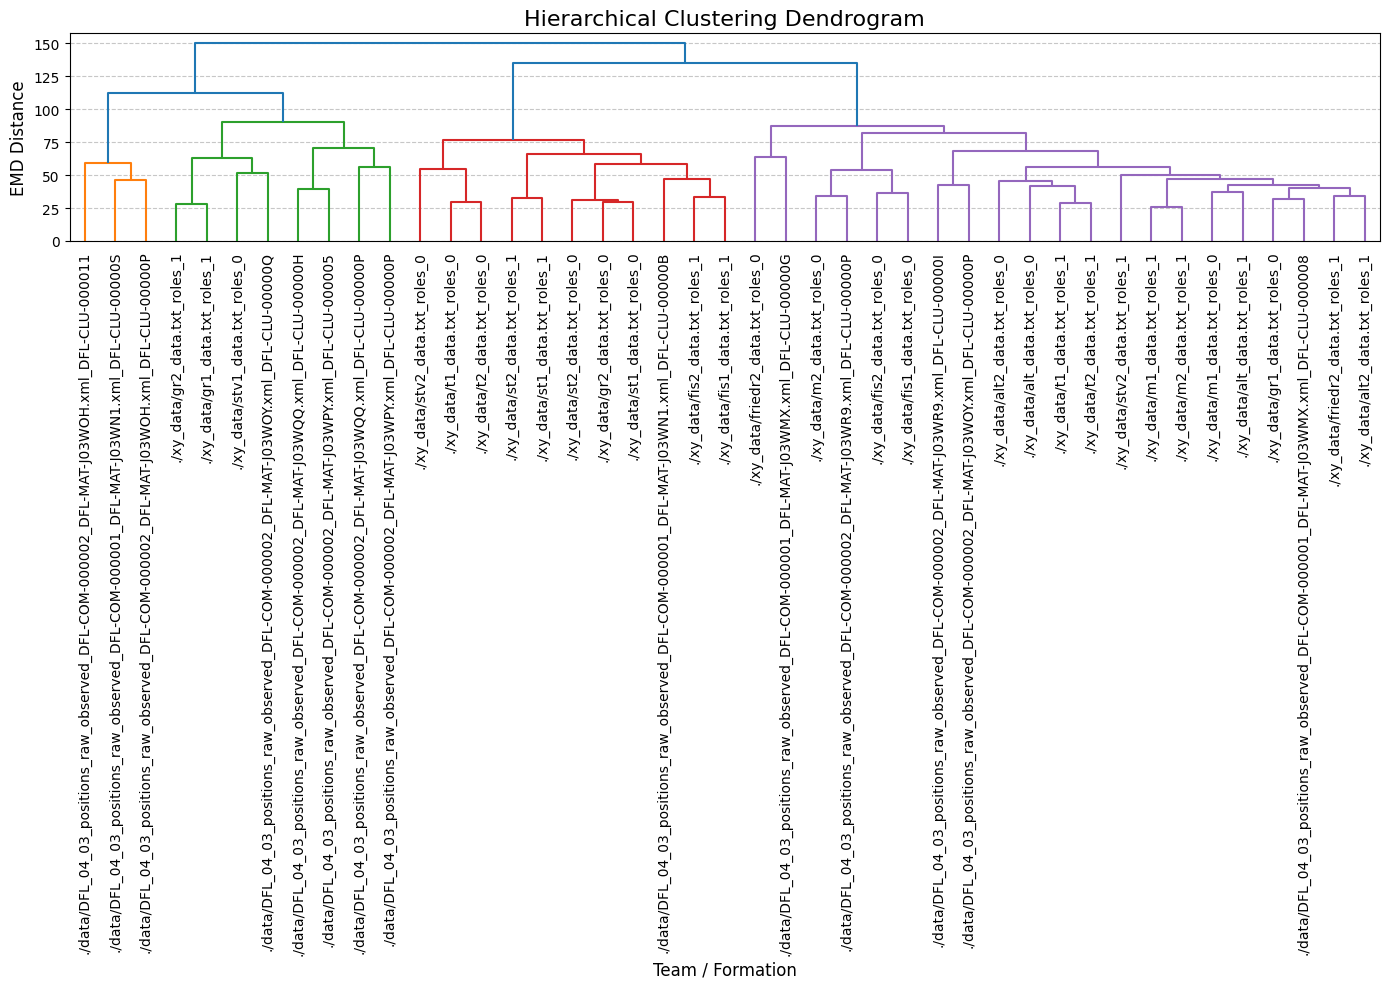

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# Convert the distance matrix to a condensed form required for hierarchical clustering
condensed_distance = squareform(distance_matrix)

# Perform hierarchical clustering using the Ward method
linkage_matrix = linkage(condensed_distance, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 10))  # Increase figure size for better readability
dendrogram(
    linkage_matrix,
    labels=team_names,
    leaf_rotation=90,  # Rotate labels for better visibility
    leaf_font_size=10  # Adjust font size for labels
)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Team / Formation', fontsize=12)
plt.ylabel('EMD Distance', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()
plt.show()

In [32]:
from sklearn.cluster import AgglomerativeClustering

# Correct the metric parameter to a valid value, e.g., 'euclidean'
clustering = AgglomerativeClustering(
    n_clusters=4,
    metric='euclidean',  # Use a valid distance metric
    linkage='ward'  # Try different linkage methods
)

cluster_labels = clustering.fit_predict(distance_matrix)

for team, label in zip(team_names, cluster_labels):
    print(f"Team {team} is in cluster {label}")


Team ./xy_data/fis2_data.txt_roles_0 is in cluster 1
Team ./xy_data/fis2_data.txt_roles_1 is in cluster 0
Team ./xy_data/gr2_data.txt_roles_0 is in cluster 0
Team ./xy_data/gr2_data.txt_roles_1 is in cluster 3
Team ./xy_data/t1_data.txt_roles_0 is in cluster 0
Team ./xy_data/t1_data.txt_roles_1 is in cluster 2
Team ./xy_data/st2_data.txt_roles_0 is in cluster 0
Team ./xy_data/st2_data.txt_roles_1 is in cluster 0
Team ./xy_data/stv2_data.txt_roles_0 is in cluster 0
Team ./xy_data/stv2_data.txt_roles_1 is in cluster 2
Team ./xy_data/m1_data.txt_roles_0 is in cluster 2
Team ./xy_data/m1_data.txt_roles_1 is in cluster 2
Team ./xy_data/friedr2_data.txt_roles_0 is in cluster 0
Team ./xy_data/friedr2_data.txt_roles_1 is in cluster 2
Team ./xy_data/t2_data.txt_roles_0 is in cluster 0
Team ./xy_data/t2_data.txt_roles_1 is in cluster 2
Team ./xy_data/alt_data.txt_roles_0 is in cluster 2
Team ./xy_data/alt_data.txt_roles_1 is in cluster 2
Team ./xy_data/alt2_data.txt_roles_0 is in cluster 2
Team 

/Users/stefanbartl/Library/Python/3.9/lib/python/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [33]:
import json

# Load JSON data
with open("merged.json", "r") as file:  # Change filename as needed
    data = json.load(file)

team_feature_vectors = {}

# Iterate over each dataset (e.g., "./xy_data/fis2_data.txt", "./xy_data/fis3_data.txt")
for dataset_key, teams in data.items():
    team_feature_vectors[dataset_key] = {}  # Store feature vectors per dataset

    # Iterate over each team (e.g., "roles_0", "roles_1")
    for team_key, players in teams.items():
        team_vector = []  # Store concatenated feature vector for this team

        # Ensure we process exactly 10 players in order
        player_keys = sorted(players.keys(), key=int)[:10]  # Sort to maintain order

        for player_key in player_keys:
            player_data = players[player_key]

            # Extract mean values
            mean = player_data["mean"]

            # Extract covariance values (flattened: σ11, σ12, σ22)
            cov_matrix = player_data["covariance"]
            cov_vector = [cov_matrix[0][0], cov_matrix[0][1], cov_matrix[1][1]]

            # Concatenate mean and covariance to form the player vector
            player_vector = mean + cov_vector

            # Append player vector to team vector
            team_vector.extend(player_vector)

        # Store the final 50D team vector
        team_feature_vectors[dataset_key][team_key] = team_vector

# Print results
for dataset, teams in team_feature_vectors.items():
    print(f"\nDataset: {dataset}")
    for team, vector in teams.items():
        print(f"  {team}: {vector[:10]}... (total {len(vector)} values)")  # Showing first 10 values for brevity



Dataset: ./xy_data/fis2_data.txt
  roles_0: [1.5126780626780614, 15.540898326210822, 22.263504980792142, 6.1418699357978, 28.046773127832704, -8.283169344042845, -12.538612672913867, 47.46618221283667, 13.633391062478443, 25.711848710164386]... (total 50 values)
  roles_1: [9.92371314699794, -13.122898033126296, 27.20076200588236, -4.943709718209393, 20.9948210073675, -14.884170579940768, 6.128014029572703, 17.914935389409994, -0.42121759943392145, 14.529165002302655]... (total 50 values)

Dataset: ./xy_data/gr2_data.txt
  roles_0: [-9.297925333333344, 18.651561777777797, 20.85713813515524, 7.431810614249028, 22.580150772826464, 10.443034666666666, -1.2150782222222214, 13.83335089373543, -3.536960720827919, 30.025001028284166]... (total 50 values)
  roles_1: [-1.6184343029979544, -23.644908815941644, 41.747830349730876, 10.882874461296643, 43.359266094727644, 7.975589333333315, 11.305216000000005, 29.304073471957615, 3.896224750059007, 18.56000646567703]... (total 50 values)

Dataset:

In [57]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load JSON data
with open("merged.json", "r") as file:  # Update with actual filename
    data = json.load(file)

# Assume `ground_truth` is a dictionary mapping (dataset, team_key) to labels
ground_truth = {  # Example labels (replace with actual labels)
    ("./xy_data/alt2_data.txt", "roles_0"): 4231,
    ("./xy_data/alt2_data.txt", "roles_1"): 442,

    ("./xy_data/alt_data.txt", "roles_0"): 4231,
    ("./xy_data/alt_data.txt", "roles_1"): 442,

    ("./xy_data/fis1_data.txt", "roles_0"): 442,
    ("./xy_data/fis1_data.txt", "roles_1"): 4231,

    ("./xy_data/fis2_data.txt", "roles_0"): 442,
    ("./xy_data/fis2_data.txt", "roles_1"): 4231,

    ("./xy_data/fried1_data.txt", "roles_1"): 442,

    ("./xy_data/friedr2_data.txt", "roles_0"): 442,
    ("./xy_data/friedr2_data.txt", "roles_1"): 442,

    ("./xy_data/gr1_data.txt.txt", "roles_0"): 4231,
    ("./xy_data/gr1_data.txt.txt", "roles_1"): 352,

    ("./xy_data/gr2_data.txt", "roles_0"): 4231,
    ("./xy_data/gr2_data.txt", "roles_1"): 352,

    ("./xy_data/m1_data.txt", "roles_0"): 442,
    ("./xy_data/m1_data.txt", "roles_1"): 442,

    ("./xy_data/m2_data.txt", "roles_0"): 442,
    ("./xy_data/m2_data.txt", "roles_1"): 442,

    ("./xy_data/st1_data.txt", "roles_0"): 4231,
    ("./xy_data/st1_data.txt", "roles_1"): 4231,

    ("./xy_data/st2_data.txt", "roles_0"): 4231,
    ("./xy_data/st2_data.txt", "roles_1"): 4231,

    ("./xy_data/stv1_data.txt", "roles_0"): 4231,

    ("./xy_data/stv2_data.txt", "roles_0"): 352,
    ("./xy_data/stv2_data.txt", "roles_1"): 442,

    # ("./xy_data/t1_data.txt", "roles_0"): 4141,
    ("./xy_data/t1_data.txt.txt", "roles_1"): 442,

    # ("./xy_data/t2_data.txt", "roles_0"): 4141,
    ("./xy_data/t2_data.txt", "roles_0"): 442,

    
   
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-00000G'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-000008'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000B'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000S'): 4231, #here 4332
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000P'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000H'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000I'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000P'): 442, #here 4422
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-000005'): 442, #here 4132
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-000011'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000Q'): 352
}


X, y = [], []

# Extract feature vectors and labels
for dataset_key, teams in data.items():
    for team_key, players in teams.items():
        if (dataset_key, team_key) in ground_truth:
            feature_vector = []
            x_coords, y_coords = [], []
            for player_id, stats in players.items():
                mean = stats["mean"]
                x_coords.append(mean[0])
                y_coords.append(mean[1])
            
            # Calculate overall mean for x and y
            overall_mean_x = np.mean(x_coords)
            overall_mean_y = np.mean(y_coords)
            
            feature_vector.extend([overall_mean_x, overall_mean_y])
            X.append(feature_vector)
            y.append(ground_truth[(dataset_key, team_key)])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)




In [58]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'NaiveBayes': GaussianNB()
}

# Leave-One-Out Cross-Validation (LOO-CV)
loo = LeaveOneOut()

# Evaluate each classifier
for classifier_name, clf in classifiers.items():
    print(f"\nEvaluating {classifier_name} using Leave-One-Out Cross-Validation...")
    accuracies = []
    reports = []

    for train_index, test_index in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracies.append(accuracy_score(y_test, y_pred))
        reports.append(classification_report(y_test, y_pred, output_dict=True))
    
    # Calculate average accuracy and report
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average Accuracy for {classifier_name}: {avg_accuracy * 100:.2f}%")
    
    # Average classification report
    avg_report = {}
    for metric in ['precision', 'recall', 'f1-score']:
        try:
            avg_report[metric] = sum([fold['weighted avg'][metric] for fold in reports if metric in fold['weighted avg']]) / len(reports)
        except KeyError:
            avg_report[metric] = None  # Handle missing metrics gracefully
    print(f"Average Classification Report for {classifier_name}:")
    print(avg_report)



Evaluating KNN using Leave-One-Out Cross-Validation...
Average Accuracy for KNN: 34.21%
Average Classification Report for KNN:
{'precision': 0.34210526315789475, 'recall': 0.34210526315789475, 'f1-score': 0.34210526315789475}

Evaluating LogisticRegression using Leave-One-Out Cross-Validation...
Average Accuracy for LogisticRegression: 44.74%
Average Classification Report for LogisticRegression:
{'precision': 0.4473684210526316, 'recall': 0.4473684210526316, 'f1-score': 0.4473684210526316}

Evaluating NaiveBayes using Leave-One-Out Cross-Validation...
Average Accuracy for NaiveBayes: 23.68%
Average Classification Report for NaiveBayes:
{'precision': 0.23684210526315788, 'recall': 0.23684210526315788, 'f1-score': 0.23684210526315788}
